In [1]:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import csv
import math
import os
import time

import numpy as np
from PIL import Image
from PIL import ImageFile
import tensorflow as tf

from google.protobuf import text_format
from delf import delf_config_pb2
from delf import box_io
from delf import feature_io
from delf import detector
from delf import extractor

# Extension of feature files.
_BOX_EXTENSION = '.boxes'
_DELF_EXTENSION = '.delf'

# Pace to report extraction log.
_STATUS_CHECK_ITERATIONS = 100

# To avoid crashing for truncated (corrupted) images.
ImageFile.LOAD_TRUNCATED_IMAGES = True

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:

def _PilLoader(path):
  """Helper function to read image with PIL.

  Args:
    path: Path to image to be loaded.

  Returns:
    PIL image in RGB format.
  """
  with tf.gfile.GFile(path, 'rb') as f:
    img = Image.open(f)
    return img.convert('RGB')


def _WriteMappingBasenameToIds(index_names_ids_and_boxes, output_path):
  """Helper function to write CSV mapping from DELF file name to IDs.

  Args:
    index_names_ids_and_boxes: List containing 3-element lists with name, image
      ID and box ID.
    output_path: Output CSV path.
  """
  with tf.gfile.GFile(output_path, 'w') as f:
    csv_writer = csv.DictWriter(
        f, fieldnames=['name', 'index_image_id', 'box_id'])
    csv_writer.writeheader()
    for name_imid_boxid in index_names_ids_and_boxes:
      csv_writer.writerow({
          'name': name_imid_boxid[0],
          'index_image_id': name_imid_boxid[1],
          'box_id': name_imid_boxid[2],
      })

In [75]:
image_path = "/mnt/datasets/daejeon_sv_v1/"
detector_model_dir = "/home/canhld/workplace/models/research/delf/delf/python/detect_to_retrieve/parameters/d2r_frcnn_20190411/"
delf_config_path = "/home/canhld/workplace/models/research/delf/delf/python/detect_to_retrieve/delf_gld_config.pbtxt"
# Parse DelfConfig proto.
config = delf_config_pb2.DelfConfig()
with tf.gfile.GFile(delf_config_path, 'r') as f:
    text_format.Merge(f.read(), config)
tf.Graph().as_default()
sess = tf.Session()
# init global variable, construc the detector
init_op = tf.global_variables_initializer()
sess.run(init_op)
detector_fn = detector.MakeDetector(
    sess, detector_model_dir, import_scope="detector")

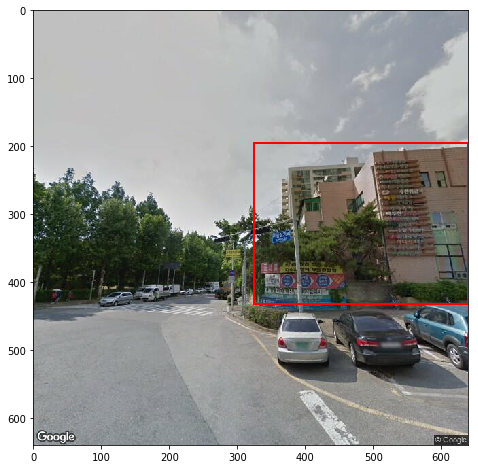

In [92]:
# extract boxes
image_name = "1993_gsv_7.jpg"
image = os.path.join(image_path, image_name)

pil_im = _PilLoader(image)
width, height = pil_im.size

# Extract and save boxes.
(boxes_out, scores_out,
class_indices_out) = detector_fn(np.expand_dims(pil_im, 0))
# Using only one image per batch.
boxes_out = boxes_out[0]
scores_out = scores_out[0]
class_indices_out = class_indices_out[0]

detector_thresh = 0.8
bboxes = []
for box_ind, box in enumerate(boxes_out):
    if scores_out[box_ind] >= detector_thresh:
        bbox = [
        int(math.floor(box[1] * width)),
        int(math.floor(box[0] * height)),
        int(math.ceil(box[3] * width)),
        int(math.ceil(box[2] * height))
        ]
        bboxes.append(bbox)
        
from matplotlib import pyplot as plt
from matplotlib import image as img
import matplotlib.patches as patches
%matplotlib inline
fig,ax = plt.subplots(figsize=(8, 8))
im = img.imread(image)
ax.imshow(im)
for bbox in bboxes:
    rect = patches.Rectangle((bbox[0],bbox[1]), bbox[2]-bbox[0],bbox[3]-bbox[1],linewidth=2,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
plt.show()